<center> <font size='6' font-weight='bold'> Puzzle Solver </font> </center>  
<center> <i> Martin  Van Waerebeke & Tony WU </i> </center>  
  
  
<img src=ressources/image_couverture.jpg>

# Préliminaires

## Modules

In [1]:
import numpy as np
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import time

from pprint import pprint

from copy import deepcopy

import sys

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import *
from main import *

# Découpage de l'image

**Rappel important**
Avec PIL, le système de coordonées pris est le suivant :
<img src=ressources/coords_system.png>

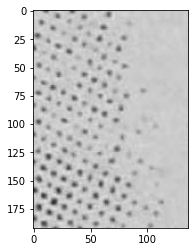

In [4]:
# Global variables, to change according to the given puzzle!
filename = 'img_test.jpg'
nb_lines = 9
nb_cols = 9

im_shuffled = read_img(filename)

cropped = split_img(im_shuffled, nb_lines, nb_cols, margin=(25,35))

plt.imshow(cropped[(0,0)])

In [5]:
save_cropped(cropped)

Images successfully saved.


In [6]:
dicBestConfig = getBestConfig(cropped, nb_lines, nb_cols)

In [7]:
ordered_list = getOrderedConfigs(dicBestConfig, reverse=False)
ordered_list

[Config(start=(6, 5), end=(7, 6), orientation='N', score=5091),
 Config(start=(7, 6), end=(6, 5), orientation='S', score=5091),
 Config(start=(4, 5), end=(7, 6), orientation='N', score=15063),
 Config(start=(0, 0), end=(1, 2), orientation='W', score=15123),
 Config(start=(1, 2), end=(0, 0), orientation='E', score=15123),
 Config(start=(8, 7), end=(1, 2), orientation='W', score=15474),
 Config(start=(1, 5), end=(3, 7), orientation='S', score=15663),
 Config(start=(3, 7), end=(1, 5), orientation='N', score=15663),
 Config(start=(2, 6), end=(3, 7), orientation='S', score=15681),
 Config(start=(7, 1), end=(1, 5), orientation='N', score=15717),
 Config(start=(0, 0), end=(1, 2), orientation='N', score=16542),
 Config(start=(1, 2), end=(0, 0), orientation='S', score=16542),
 Config(start=(1, 0), end=(3, 7), orientation='S', score=17082),
 Config(start=(2, 5), end=(6, 5), orientation='S', score=17436),
 Config(start=(3, 8), end=(1, 0), orientation='N', score=17508),
 Config(start=(3, 8), end=(

In [8]:
main(ListFit=ordered_list, n=9)

TypeError: can only concatenate tuple (not "list") to tuple